# Extract spectra of vector shape (e.g., craters and boulders)

In [1]:
# UNCOMMENT WHEN YOU USE Google colab
'''
# Library install
!pip install rasterio

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
'''

# Set output folder
out_folder = './output/'

In [2]:
import numpy as np
import rasterio
from rasterio import features
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio.plot import show

import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

## Extract spectra from ONC data
- Input files: ONC multi-band map (GeoTIFF), vector shape (GeoPackage)

In [3]:
#Input file: ONC multi-band map (GeoTIFF)
in_raster = './data/hyb2_onc_mos_20181003_MascotSeparation.tif'

#Input file: vector shape file (GeoPackage)
in_vector = './data/bolder_extract.gpkg'


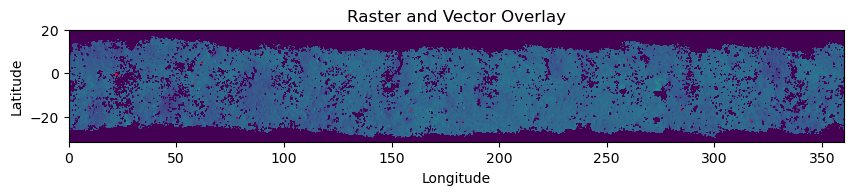

In [4]:
# Visualize the input files

# Read the raster data
with rasterio.open(in_raster) as src:
    raster_data = src.read(3)  # Read the v band
    raster_meta = src.meta
    raster_bounds = src.bounds

# Read the vector data
vector_data = gpd.read_file(in_vector)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Display the raster
show(raster_data, transform=raster_meta['transform'], ax=ax,vmin=0.01, vmax=0.03)

# Plot the vector outlines
vector_data.boundary.plot(ax=ax, color='red', linewidth=1) #added linewidth for better visibility

# Set plot extent for better visualization (optional)
ax.set_xlim(raster_bounds.left, raster_bounds.right)
ax.set_ylim(raster_bounds.bottom, raster_bounds.top)

# Add labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Raster and Vector Overlay")

# Display the plot
plt.show()

In [5]:
#ベクトルでループ／マスク範囲の画素値を取得
gdf = gpd.read_file(in_vector)
results = []

with rasterio.open(in_raster) as src:
    for _, row in gdf.iterrows():
        # ポリゴンのジオメトリを取得
        geom = [row.geometry]

        # ポリゴンでラスターデータをマスク
        out_image, out_transform = mask(src, geom, all_touched=True, crop=True, nodata=np.nan)

        # 各バンドについて統計値を計算
        band_mean = []
        for band_index in range(out_image.shape[0]):  # バンドの数だけループ
            # マスク後のデータを取得
            masked_data = out_image[band_index]

            # 有効なピクセル値（NaN以外）を取得
            valid_data = masked_data[~np.isnan(masked_data)]

            # 統計値を計算
            band_mean.append(np.mean(valid_data))

        # 結果をリストに追加
        results.append(band_mean)

print(results)

# GDB化
gdf_ONCresults = gdf[["geometry"]].copy()
gdf_ONCresults["polygon_id"] = range(1, len(gdf_ONCresults) + 1)

for band_index in range(len(results[0])):
    gdf_ONCresults[f"mean_band_{band_index + 1}"] = [means[band_index] for means in results]



[[0.018108834, 0.017077183, 0.017265366, 0.017326556, 0.01737788, 0.017890308, 0.017641567], [0.01928963, 0.018378928, 0.018672984, 0.018818203, 0.018832993, 0.019110834, 0.018672222], [0.018410802, 0.017478446, 0.017848322, 0.017834285, 0.017803235, 0.018179962, 0.017718906], [0.01833997, 0.017176118, 0.017234012, 0.017407682, 0.017460562, 0.018123772, 0.017662542], [0.019520937, 0.01854068, 0.018742178, 0.018859565, 0.018863602, 0.01930435, 0.018823002], [0.017877784, 0.016803939, 0.017191043, 0.017099623, 0.017020248, 0.017560303, 0.017292757], [0.01848809, 0.017393121, 0.017549226, 0.017542733, 0.017488396, 0.017644519, 0.017149074], [0.018144066, 0.017199134, 0.017355543, 0.01738465, 0.017368905, 0.01745696, 0.017056089], [0.018019767, 0.017284108, 0.01750324, 0.017705513, 0.017584715, 0.01788088, 0.017273061], [0.018592266, 0.017655874, 0.017892944, 0.017987197, 0.018121185, 0.018667253, 0.018336639], [0.020305762, 0.019355731, 0.019566372, 0.019680412, 0.019386161, 0.0199454, 0.

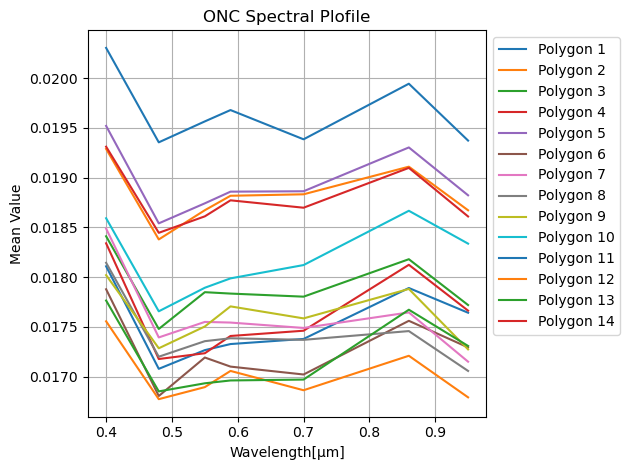

In [6]:
# グラフの設定

wl = [0.40,0.48,0.55,0.589,0.70,0.86,0.95]
wl = np.array(wl)

mean_columns = gdf_ONCresults.filter(like='mean_').columns

for polygon_id in gdf_ONCresults['polygon_id']:
    y_values = gdf_ONCresults[gdf_ONCresults['polygon_id'] == polygon_id][mean_columns].values.flatten()
    plt.plot(wl, y_values, linestyle='-',label=f'Polygon {polygon_id}')

plt.title('ONC Spectral Plofile')
plt.xlabel('Wavelength[μm]')
plt.ylabel('Mean Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()

In [7]:
gdf_ONCresults

,geometry,polygon_id,mean_band_1,mean_band_2,mean_band_3,mean_band_4,mean_band_5,mean_band_6,mean_band_7
0,"POLYGON ((22.39815 -0.3786, 22.57509 -0.59636,...",1,0.018109,0.017077,0.017265,0.017327,0.017378,0.017890,0.017642
1,"POLYGON ((284.63621 -16.69064, 284.78422 -16.7...",2,0.019290,0.018379,0.018673,0.018818,0.018833,0.019111,0.018672
2,"POLYGON ((259.3294 5.84815, 259.39405 5.9128, ...",3,0.018411,0.017478,0.017848,0.017834,0.017803,0.018180,0.017719
3,"POLYGON ((253.50416 -20.92007, 253.53819 -20.9...",4,0.018340,0.017176,0.017234,0.017408,0.017461,0.018124,0.017663
4,"POLYGON ((183.08404 -22.57373, 183.13167 -22.6...",5,0.019521,0.018541,0.018742,0.018860,0.018864,0.019304,0.018823
5,"POLYGON ((159.44961 -17.00028, 159.45641 -17.1...",6,0.017878,0.016804,0.017191,0.017100,0.017020,0.017560,0.017293
6,"POLYGON ((148.9492 7.78423, 148.99343 7.73319,...",7,0.018488,0.017393,0.017549,0.017543,0.017488,0.017645,0.017149
7,"POLYGON ((129.84702 -1.12207, 129.8198 -1.2343...",8,0.018144,0.017199,0.017356,0.017385,0.017369,0.017457,0.017056
8,"POLYGON ((78.12246 -20.66998, 78.06632 -20.698...",9,0.018020,0.017284,0.017503,0.017706,0.017585,0.017881,0.017273
9,"POLYGON ((61.83254 4.87841, 61.84955 4.68787, ...",10,0.018592,0.017656,0.017893,0.017987,0.018121,0.018667,0.018337


In [8]:
# 結果をGeoPackageとして保存
out_path = out_folder + 'output_results_ONC.gpkg'
gdf_ONCresults.to_file(out_path, driver="GPKG")


## Extract spectra from NIRS3 data
- Input files: NIRS3 vector file (GeoPackage), vector shape (GeoPackage)

In [11]:
# Input file: NIRS3 vector file
vector1_path = './data/hyb2_nirs3_20180711_01_l2d_geo.gpkg' 

# Input file: Geometry (crater or boulder) vector file
vector2_path = './data/bolder_extract.gpkg' 

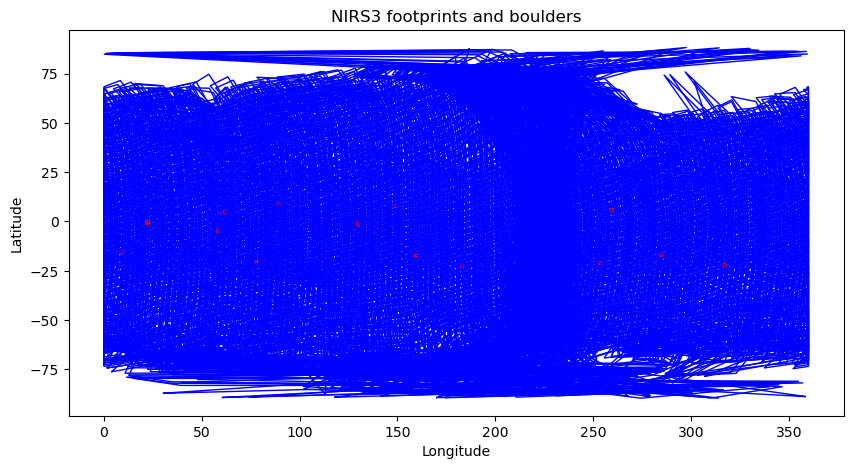

In [12]:

# Read the vector data
vector1_data = gpd.read_file(vector1_path)
vector2_data = gpd.read_file(vector2_path)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the vector outlines
vector1_data.boundary.plot(ax=ax, color='blue', linewidth=1)
vector2_data.boundary.plot(ax=ax, color='red', linewidth=3)

# Set plot title and labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("NIRS3 footprints and boulders")

# Display the plot
plt.show()

In [13]:
# Set NIRS3 wavelengths
n=np.arange(128)+1
wl_all=(1230.33+18.5651*n-0.00492138*n**2)/1000.

In [14]:
# GeoDataFrameを読み込み
gdf1 = gpd.read_file(vector1_path)  # 属性値を集計する対象
gdf2 = gpd.read_file(vector2_path)  # 集計範囲となるポリゴン

# 投影法を統一
#if gdf1.crs != gdf2.crs:
#    gdf2 = gdf2.to_crs(gdf1.crs)

# 結果を保存するリスト
results = []

#対象フィールドの絞込（wlを含むフィールドのみを計算対象とする）
target_fields = [col for col in gdf1.columns if "wl" in col and gdf1[col].dtype in [float, int]]

# gdf2の各ポリゴンについて処理
for _, poly_row in gdf2.iterrows():
    # gdf1とgdf2のポリゴンを重ね合わせてオーバーラップする部分を抽出
    overlap = gdf1[gdf1.geometry.intersects(poly_row.geometry)]

    # オーバーラップする部分をクリップ（重なり部分のみ取得）
    overlap = overlap.copy()
    overlap["geometry"] = overlap.geometry.intersection(poly_row.geometry)

    # 各属性フィールドごとに平均値を計算
    stats = {"polygon_id": (_ + 1)}   # gdf2のポリゴンID（必要に応じて調整）

    #for column in gdf1.columns:
    for column in target_fields:
        if column != "geometry" and gdf1[column].dtype in [float, int]:  # 数値列のみ対象
            stats[column + "_mean"] = overlap[column].mean()

    # 結果を追加
    results.append(stats)

['wl27_mean', 'wl28_mean', 'wl29_mean', 'wl30_mean', 'wl31_mean', 'wl32_mean', 'wl33_mean', 'wl34_mean', 'wl35_mean', 'wl36_mean', 'wl37_mean', 'wl38_mean', 'wl39_mean', 'wl40_mean', 'wl41_mean', 'wl42_mean', 'wl43_mean', 'wl44_mean', 'wl45_mean', 'wl46_mean', 'wl47_mean', 'wl48_mean', 'wl49_mean', 'wl50_mean', 'wl51_mean', 'wl52_mean', 'wl53_mean', 'wl54_mean', 'wl55_mean', 'wl56_mean', 'wl57_mean', 'wl58_mean', 'wl59_mean', 'wl60_mean', 'wl61_mean', 'wl62_mean', 'wl63_mean', 'wl64_mean', 'wl65_mean', 'wl66_mean', 'wl67_mean', 'wl68_mean', 'wl69_mean', 'wl70_mean', 'wl71_mean', 'wl72_mean', 'wl73_mean', 'wl74_mean', 'wl75_mean', 'wl76_mean', 'wl77_mean', 'wl78_mean', 'wl79_mean', 'wl80_mean', 'wl81_mean', 'wl82_mean', 'wl83_mean', 'wl84_mean', 'wl85_mean', 'wl86_mean', 'wl87_mean', 'wl88_mean', 'wl89_mean', 'wl90_mean', 'wl91_mean', 'wl92_mean', 'wl93_mean', 'wl94_mean', 'wl95_mean', 'wl96_mean', 'wl97_mean', 'wl98_mean', 'wl99_mean', 'wl100_mean', 'wl101_mean', 'wl102_mean', 'wl103_m

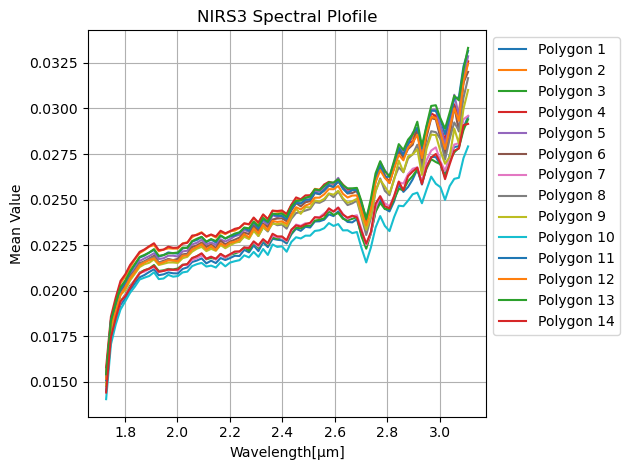

In [15]:
# 結果を表示
df_results = pd.DataFrame(results)
target_columns = [col for col in df_results.columns if col.endswith("_mean")]
target_columns = target_columns[26:104]
wl = wl_all[26:104]
print(target_columns)

for polygon_id in df_results['polygon_id']:
    polygon_data = df_results[df_results['polygon_id'] == polygon_id]
    #plt.plot(target_columns, polygon_data[target_columns].values.flatten(), label=f'Polygon {polygon_id}')
    #print(polygon_data)
    y_values = polygon_data[target_columns].values.flatten()

    if len(y_values) == len(target_columns) and len(y_values) == len(wl):
        #plt.scatter(wl, y_values, label=f'Polygon {polygon_id}',s=1)
        plt.plot(wl, y_values, linestyle='-',label=f'Polygon {polygon_id}')
    else:
        print(f"Warning: Polygon {polygon_id} has mismatched data size")

# グラフの設定
plt.title('NIRS3 Spectral Plofile')
plt.xlabel('Wavelength[μm]')
plt.ylabel('Mean Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()


In [16]:
# prompt: gdf_ONCresultsとdf_resultsをpolygon_idに基づいて結合する

# Assuming 'polygon_id' is a common column in both GeoDataFrames
merged_gdf = gdf_ONCresults.merge(df_results, on='polygon_id', how='inner')
# how='inner' ensures that only rows with matching 'polygon_id' are kept
# Other options for 'how' include 'left', 'right', 'outer'

# Now 'merged_gdf' contains the combined data
merged_gdf

,geometry,polygon_id,mean_band_1,mean_band_2,mean_band_3,mean_band_4,mean_band_5,mean_band_6,mean_band_7,wl1_mean,...,wl119_mean,wl120_mean,wl121_mean,wl122_mean,wl123_mean,wl124_mean,wl125_mean,wl126_mean,wl127_mean,wl128_mean
0,"POLYGON ((22.39815 -0.3786, 22.57509 -0.59636,...",1,0.018109,0.017077,0.017265,0.017327,0.017378,0.017890,0.017642,-1.900362e-09,...,0.679585,0.845606,1.156983,1.949050,3.139686,5.546395,10.333745,16.926580,25.496215,37.120614
1,"POLYGON ((284.63621 -16.69064, 284.78422 -16.7...",2,0.019290,0.018379,0.018673,0.018818,0.018833,0.019111,0.018672,-3.233845e-09,...,0.881579,1.087017,1.518370,2.257715,4.012860,6.911577,12.739493,21.638098,32.871092,48.826445
2,"POLYGON ((259.3294 5.84815, 259.39405 5.9128, ...",3,0.018411,0.017478,0.017848,0.017834,0.017803,0.018180,0.017719,-1.439868e-09,...,0.647059,0.830710,1.124644,1.693144,3.018300,5.308835,9.659445,16.628577,23.979356,35.207021
3,"POLYGON ((253.50416 -20.92007, 253.53819 -20.9...",4,0.018340,0.017176,0.017234,0.017408,0.017461,0.018124,0.017663,-3.083254e-09,...,0.842254,1.180623,1.608370,2.363994,4.138195,7.169798,13.112885,21.885145,33.453543,48.339998
4,"POLYGON ((183.08404 -22.57373, 183.13167 -22.6...",5,0.019521,0.018541,0.018742,0.018860,0.018864,0.019304,0.018823,-4.469007e-09,...,1.066397,1.301608,1.675621,2.658653,4.579071,7.533001,14.532814,24.738883,38.598882,57.633657
5,"POLYGON ((159.44961 -17.00028, 159.45641 -17.1...",6,0.017878,0.016804,0.017191,0.017100,0.017020,0.017560,0.017293,-4.793048e-09,...,1.140511,1.385274,1.905276,2.914533,4.870269,7.928213,15.280173,25.882581,39.855940,60.933840
6,"POLYGON ((148.9492 7.78423, 148.99343 7.73319,...",7,0.018488,0.017393,0.017549,0.017543,0.017488,0.017645,0.017149,-2.042451e-09,...,0.738985,0.994593,1.520573,2.069493,3.584544,5.879165,10.767318,18.138888,26.962578,38.760923
7,"POLYGON ((129.84702 -1.12207, 129.8198 -1.2343...",8,0.018144,0.017199,0.017356,0.017385,0.017369,0.017457,0.017056,-3.424307e-09,...,0.860905,1.114868,1.392561,2.332708,3.891673,6.670549,12.711275,21.371730,32.499112,48.595276
8,"POLYGON ((78.12246 -20.66998, 78.06632 -20.698...",9,0.018020,0.017284,0.017503,0.017706,0.017585,0.017881,0.017273,-3.914144e-09,...,1.028584,1.203413,1.633720,2.589309,4.225960,7.211378,13.553865,23.259445,35.057157,52.718572
9,"POLYGON ((61.83254 4.87841, 61.84955 4.68787, ...",10,0.018592,0.017656,0.017893,0.017987,0.018121,0.018667,0.018337,-1.310642e-09,...,0.457399,0.724856,0.835689,1.593408,2.780690,4.656910,8.789054,15.177674,22.681523,32.894214


In [17]:
#results_df = pd.DataFrame(results)
gdf2_results = gdf2[["geometry"]].copy()

# 統計量をpolygon_idに基づいて結合
#gdf2_results_combined = pd.concat([gdf2_results, df_results], axis=1)
gdf2_results_combined = gdf_ONCresults.merge(df_results, on='polygon_id', how='inner')

# 結果をGeoDataFrameとして保存
gdf2_results = gpd.GeoDataFrame(gdf2_results_combined, geometry="geometry", crs=gdf1.crs)

# 結果をGeoPackageとして保存
out_path = out_folder + 'output_results.gpkg'
gdf2_results.to_file(out_path, driver="GPKG")
